In [ ]:
from datetime import datetime
import torch
from torchcam.methods import XGradCAM
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]


In [ ]:

FINDINGS = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
    'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema',
    'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

In [ ]:
# Suponha que model seja o seu modelo carregado
model = torch.load('results/densenet_best.pth')['model']
model.eval()
model.cpu()

In [ ]:
# Função para carregar a imagem e transformá-la em um tensor
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD)
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

In [ ]:
# Função para obter as principais probabilidades e índices
def get_top_probabilities(output, topk=3):
    # Aplicar softmax para obter probabilidades
    probabilities = torch.nn.functional.softmax(output, dim=1)
    top_probs, top_idxs = torch.topk(probabilities, topk)
    return top_probs.squeeze(), top_idxs.squeeze()

In [ ]:
def generate_cam(image_tensor, model, top_idx, original_image_size):
    # Inicialize o extrator de CAM com o modelo e a camada-alvo
    cam_extractor = XGradCAM(model, target_layer=model.features.norm5)  # Verifique se 'norm5' é o correto para o seu modelo
    
    # Realize a passagem para frente através do modelo
    out = model(image_tensor)
    # Calcule o CAM para a classe de interesse
    activation_map = cam_extractor(out.squeeze().argmax().item(), out)
    
    # Verifica se o mapa de ativação é uma lista e pega o primeiro item se for
    if isinstance(activation_map, list):
        activation_map = activation_map[0]
    
    # Redimensiona o CAM para o tamanho da imagem de entrada
    result = transforms.Resize(original_image_size)(activation_map.unsqueeze(0))
    
    # Normaliza o CAM para ter valores entre 0 e 1 para melhor visualização
    result = result.squeeze().numpy()
    result = (result - result.min()) / (result.max() - result.min())

    return result

In [ ]:
def process_image(image_path, model):
    image_tensor = load_image(image_path)
    original_image = Image.open(image_path).convert('RGB')
    original_image_size = original_image.size  # Obter o tamanho da imagem original
    output = model(image_tensor)
    top_probs, top_idxs = get_top_probabilities(output)
    
    # Gera o CAM para cada um dos top_idxs
    cams = [generate_cam(image_tensor, model, idx, original_image_size) for idx in top_idxs]
    
    # Exibe a imagem original e os CAMs
    plt.figure(figsize=(20, 10))
    for i, (cam, idx) in enumerate(zip(cams, top_idxs)):
        plt.subplot(1, len(top_idxs), i+1)
        plt.imshow(original_image, alpha=1)
        plt.imshow(cam, cmap='hot', alpha=0.5)  # Ajuste de transparência para o CAM
        plt.title(f"{FINDINGS[idx]}: {top_probs[i].item():.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.show()
    
    
    # Apresentando os resultados de texto
    print(f"As principais probabilidades são: {top_probs.detach().numpy()}")
    print(f"Achados correspondentes: {[FINDINGS[i] for i in top_idxs]}")

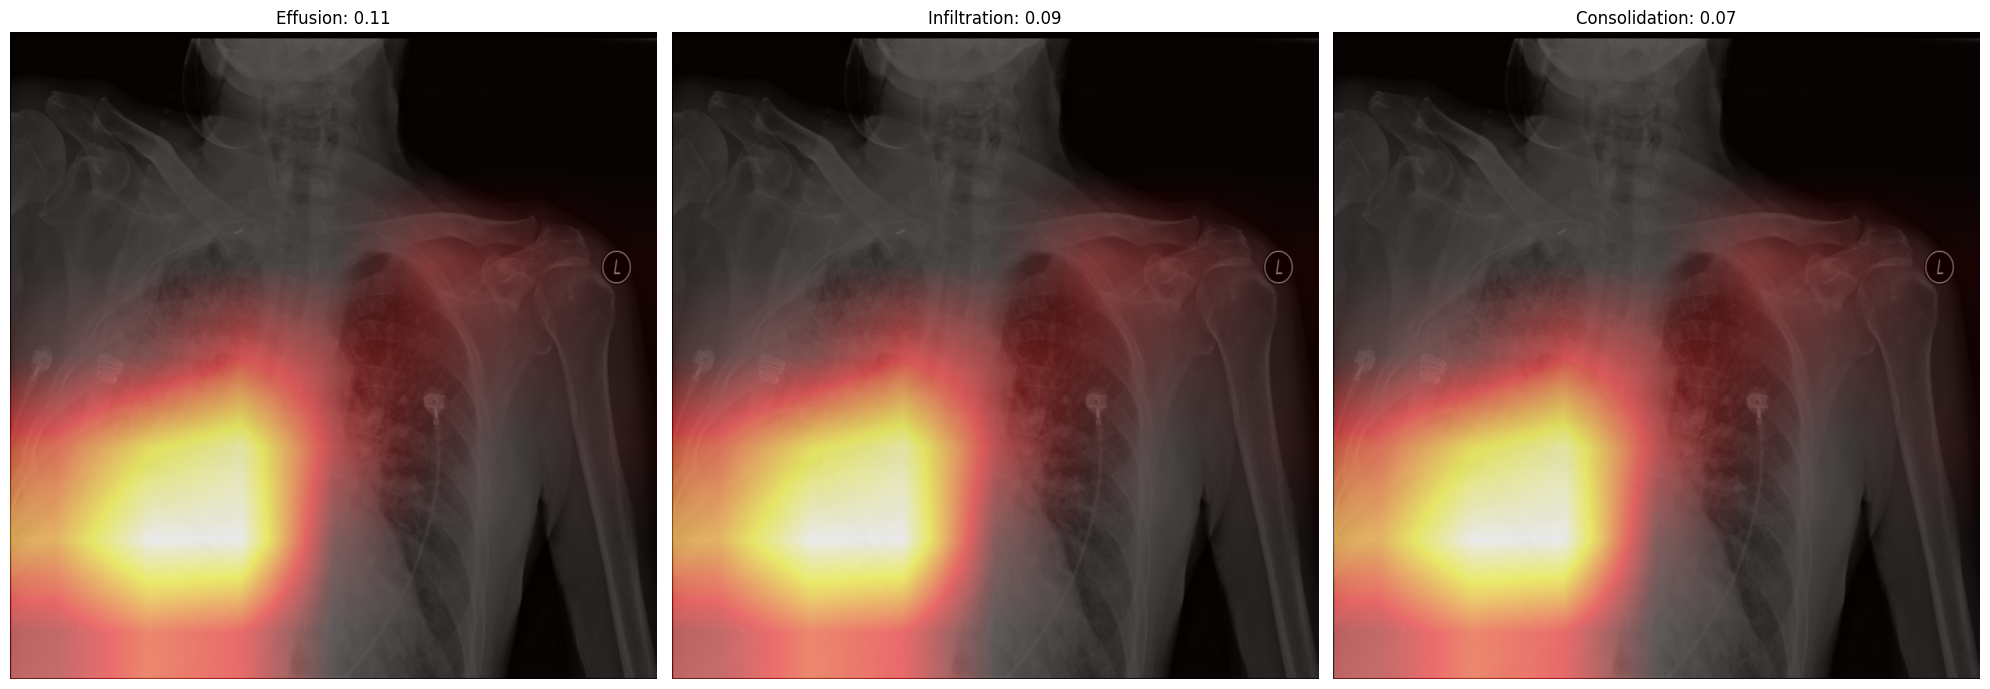

As principais probabilidades são: [0.11205439 0.09185203 0.07491345]
Achados correspondentes: ['Effusion', 'Infiltration', 'Consolidation']


In [64]:
# Exemplo de uso
image_path = 'images/00021725_000.png'
process_image(image_path,model)